In [54]:
import random

import matplotlib.pyplot as plt
import numpy
# Used for Fourier Analysis of results
from scipy import fftpack

In [55]:
a = -20.0
b = 20.0
n = 2 ** 10 + 1
# n = 10
h = (b - a) / n
inv_h_sq = h ** -2
half_h = h * 0.5

In [56]:
hbar = 1.054571817 * 10 ** -34  # eV
m = 9.1093837015 * 10 ** -31  # kg
factor = -hbar ** 2 / (2 * m)

In [57]:
x = numpy.linspace(a, b, num=n, dtype=complex)
k = 0.01
V = numpy.zeros(n)
# V = 0.5 * k * x ** 2

In [58]:
# Array containing all the H(psi)
global hamiltonians_array
# The tiny psi x H(psi)
global infinitesimal_energy_expectations
# The actual [psi x H(psi)]dx to sum over
global energies_array
# Array of magnitudes of the psi
global normalisation_array
# psi itself
global psi
# The actual <E> as a sum of the tiny <E>
global E
# The magnitude to normalise psi by
global norm

In [59]:
norm = 0

hamiltonians_array = numpy.zeros(n, dtype=complex)

infinitesimal_energy_expectations = numpy.zeros(n)
energies_array = numpy.zeros(n)
is_normalised = False
normalisation_array = numpy.zeros(n)
E = 0

In [60]:
psi = numpy.linspace(1, 1, n, dtype=complex)
mag_psi = psi.conj() * psi

In [61]:
# number_iterations = 10000
number_iterations = 50000

In [62]:
def re_integrate(i: int, f: numpy.ndarray, step=h):
    # rectangular rule, at only the given index to change the array
    # sum the array after

    # f_i = Is[i]
    # Loop the indices back to the start if they overflow
    # f_i_plus_i = Is[(i + 1) % n]
    # Es[i] = (f_i + f_i_plus_i) * half_h

    # Central Difference Rule:
    # length = len(f)
    # f_i = f[i]
    # f_i_plus_1 = f[(i + 1) % length]
    # out[i] = (f_i + f_i_plus_1) * 0.5 * step

    # Rectangular Rule:
    return f[i] * step

In [63]:
def second_derivative(f: numpy.ndarray, i: int, wrap=False):
    """
    Calculates the 2nd order finite difference on the array f at the index i. If wrap is False,
    The edge cases are calculated using the forward and backward differences respectively, otherwise the central
    difference method is used throughout.
    :param f: The array to perform the differentiation on.
    :param i: The index to perform the differentiation at.
    :param wrap: Whether the edge cases wrap around or not.
    :return: The second order derivative at the index i.
    """
    # https: // en.wikipedia.org / wiki / Finite_difference
    # h = step size
    # Centre difference 2nd Derivative: d^2f / dx^2 = f''(x):
    # 1/h**2 * [f_i+1 - 2f_i + f_i-1]
    length = len(f)

    if not wrap and i + 1 >= length:
        # Use second order backward instead:
        # f'' = 1/h**2 * [f_i + f_i-2 - 2f_i-1]
        f_i = f[i]
        f_i_minus_1 = f[i - 1]
        f_i_minus_2 = f[i - 2]

        div2 = inv_h_sq * (f_i - 2 * f_i_minus_1 + f_i_minus_2)
        return div2

    if not wrap and i - 1 < 0:
        # Use second order forward instead:
        # f'' = 1/h**2 * [f_i + f_i+2 - 2f_i+1]
        f_i = f[i]
        f_i_plus_1 = f[i + 1]
        f_i_plus_2 = f[i + 2]

        div2 = inv_h_sq * (f_i - 2 * f_i_plus_1 + f_i_plus_2)
        return div2

    # Prevent the index going out of range, by looping back the index if it's too high
    f_i_plus_1 = f[(i + 1) % length]
    # Assume that the current index is in range
    f_i = f[i]
    # The lower index inherently loops back using negative indexing
    f_i_minus_1 = f[i - 1]

    # Current derivative.
    div_2 = inv_h_sq * (f_i_plus_1 - 2 * f_i + f_i_minus_1)
    return div_2

In [64]:
def hamil(psi: numpy.ndarray, i: int):
    """
    Calculates the Hamiltonian of the given psi wavefunction at the given index in the array.
    :param psi: The wavefunction to operate on.
    :param i: The index to do the operation at.
    :return: The hamiltonian value at index i for the given psi.
    """
    # Tp = factor * second_derivative(psi)
    # Vp = V * psi
    # Hp = Tp + Vp
    # return Hp

    # Hp[i] = Tpi + Vpi
    # pass

    Tpi = factor * second_derivative(psi, i)
    Vpi = V[i] * psi[i]
    # Hpi = Tpi + Vpi
    # return Hpi
    # hamiltonians_array[i] = Tpi + Vpi
    return Tpi + Vpi

In [65]:
def recalculate_energy(psi: numpy.ndarray, i: int):
    """
    Recalculates the <E> at the given i for the given psi.
    :param psi: The wavefunction to use for the expectation value.
    :param i: The index to perform the calculation at.
    """
    # psi*
    # H psi
    # I = psi* x H psi
    # get at index i
    # Change array entry at only this point,
    # Then sum the array
    global hamiltonians_array
    global energies_array
    global infinitesimal_energy_expectations

    # alters the H*psi value at index i
    hamiltonians_array[i] = hamil(psi, i)

    infinitesimal_energy_expectations[i] = (psi[i].conj() * hamiltonians_array[i]).real

    # re_integrate(i)
    energies_array[i] = re_integrate(i, infinitesimal_energy_expectations)

In [66]:
def energy_expectation():
    """
    Calculates the <E> energy expectation value from the energues_array array
    :return: The energy expectation value <E> as a scalar.
    """
    # global E
    # E = numpy.sum(energies_array).real
    # return E
    non_normalised_E = numpy.sum(energies_array).real
    normalised_E = non_normalised_E / norm
    return normalised_E
    # return numpy.sum(energies_array).real

In [67]:
def re_norm(psi: numpy.ndarray, i: int):
    """
    Recalculates the normalisation for the given psi wavefunction at the index i.
    :param psi: The wavefunction to re normalise.
    :param i: The index to perform the normalisation at.
    """
    global mag_psi
    global normalisation_array
    global is_normalised

    mag_psi[i] = psi[i].conj() * psi[i]
    normalisation_array[i] = re_integrate(i, mag_psi).real

    is_normalised = False
    # return re_integrate(i, mag_psi)

In [68]:
def normalise_arrays(psi : numpy.ndarray):
    """
    Re-normalise the arrays using the normalisations calculated by re_norm()
    :param psi: The wavefunction to normalise.
    """
    # Assumes that norms has been properly calculated...
    global is_normalised
    global mag_psi
    global normalisation_array
    global norm

    if not is_normalised:
        norm = numpy.sum(normalisation_array)
        mag_psi /= norm
        normalisation_array /= norm
        is_normalised = True

In [69]:
def normalise(psi: numpy.ndarray):
    """
    Re-normalise the wavefunction psi, using the normalisation factors pre calculated from normalisation_array.
    :param psi: The wavefunction to normalise.
    :return: The normalised wavefunction.
    """
    # Assumes that norms has been properly calculated...
    global is_normalised
    global mag_psi
    global normalisation_array
    global norm

    # if not is_normalised:
    #     norm = numpy.sum(normalisation_array)
    #     psi /= numpy.sqrt(norm)
    #     mag_psi /= norm
    #     normalisation_array /= norm
    #     is_normalised = True
    #     return psi
    # else:
    #     return psi
    normalise_arrays(psi)
    psi /= numpy.sqrt(norm)
    return psi

    # norm = numpy.sum(normalisation_array)
    # psi /= numpy.sqrt(norm)
    # normalisation_array /= norm
    # return psi

    # is_normalised = True

In [70]:
def tweak_psi(psi: numpy.ndarray, pos: int, tweak: complex):
    """
    Changes the given wavefunction at the given index by the given amount, and renormalises the result.
    Calculates the new <E> for this changed wave function as well.
    :param psi: The wavefunction to modify.
    :param pos: The index of the wavefunction to modify.
    :param tweak: The amount to modify by.
    :return: A tuple of the wavefunction and it's corresponding <E>.
    """
    # Tweak the value in psi by the given amount
    psi[pos] += tweak

    # Recompute the normalisation for this entry
    re_norm(psi, pos)
    # Re normalise psi
    psi = normalise(psi)

    # Re calculate the energy at this entry as well
    recalculate_energy(psi, pos)
    # The tweaked energy value is the new <E>
    E_new = energy_expectation()

    return psi, E_new

In [71]:
def ground_state(psi_start: numpy.ndarray, number_iterations: int, seed="The Variational Principle"):
    """
    Calculates the ground state wavefunction for a given potential system, by fiinding the wavefunction with
    minimum expectation value in the energy <E>.
    :param psi_start: The initial wavefunction guess.
    :param number_iterations: Number of times the wavefunction should be modified to obtain the final result.
    :param seed: A seed for the random number generator.
    :return: The normalised gorund state wavefunction.
    """
    global energies_array
    global infinitesimal_energy_expectations
    global is_normalised
    global E

    # Set the default wavefunction
    psi = psi_start
    # psi is already normalised by initialise()
    # and E is already calculated.

    # Get the random number generator, uses the given seed so that the results are repeatable
    random.seed(seed)

    # Iterate for the number of desired iterations
    for i in range(number_iterations):

        # Get a random x coord to sample
        rand_x = random.randrange(0, n)

        # Generate a random number to alter the entry by.
        rand_y = 0
        imaginary_part = random.randint(0, 1)
        # True is the imaginary part:
        if imaginary_part:
            rand_y = complex(0, random.random())
        else:
            rand_y = complex(random.random())

        # rand_y_real = random.random()
        # rand_y_imag = random.random()
        # rand_y = complex(rand_y_real, rand_y_imag)

        #
        # # Tweak the value in psi upward
        # psi[rand_x] += rand_y

        # # Recompute the normalisation for this entry
        # re_norm(psi, rand_x)
        # # Re normalise psi
        # psi = normalise(psi)
        # normalise_arrays(psi)

        # # Re calculate the energy at this entry as well
        # recalculate_energy(psi, rand_x)
        # # The tweaked up value is the new <E>
        # E_up = energy_expectation()
        psi, E_up = tweak_psi(psi, rand_x, rand_y)
        #
        # # Tweak the value in psi downward from the original psi value
        # psi[rand_x] -= 2 * rand_y
        # # Re normalise
        # re_norm(psi, rand_x)
        # psi = normalise(psi)
        #
        # # Calculate <E> for this change again.
        # recalculate_energy(psi, rand_x)
        # E_down = energy_expectation()
        psi, E_down = tweak_psi(psi, rand_x, -2 * rand_y)
        #
        # # reset psi to the original value
        # psi[rand_x] += rand_y
        # re_norm(psi, rand_x)
        # psi = normalise(psi)
        psi, E = tweak_psi(psi, rand_x, rand_y)

        # Compare energies for tweaking the entry up versus down, and keep the change
        # that results in a lower overall expectation value for the energy.
        if E_up < E_down and E_up < E:

            # If increasing the value in the entry results in a lower overall <E>
            # set the change and keep it
            psi[rand_x] += rand_y
            E = E_up
            re_norm(psi, rand_x)
            psi = normalise(psi)

        elif E_down < E_up and E_down < E:

            # If decreasing the entry results in a lower overall <E>,
            # reduce the value and keep it.
            psi[rand_x] -= rand_y
            E = E_down
            re_norm(psi, rand_x)
            psi = normalise(psi)

        # otherwise the psi should be left unchanged.
        # Same goes for Is, Es, norms, and the normalisation.

    # Normalise the final wavefunction
    # psi = normalise_psi(psi)
    psi = normalise(psi)
    return psi

In [72]:
# p(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }} e^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} },
def generate_psi():
    """
    Creates a Gaussian distribution for the wavefunction psi
    :return:
    """
    global psi
    mu = complex((a + b) / 2.0)
    sigma = complex((b - a) / 4.0)
    pi = complex(numpy.pi)
    A = 1 / numpy.sqrt(2 * pi * sigma ** 2)
    B = numpy.exp(- ((x - mu) ** 2) / (2 * sigma ** 2))
    psi = A * B

In [73]:
def initialise():
    """
    Sets the initial values for the global arrays.
    :return:
    """
    global E
    global psi

    for i in range(n):
        re_norm(psi, i)
    psi = normalise(psi)

    for i in range(n):
        recalculate_energy(psi, i)

    # mag_psi = numpy.sum(norms)
    # psi = psi / numpy.sqrt(mag_psi)
    E = energy_expectation()

In [74]:
generate_psi()

In [75]:
initialise()
for i in range(n):
    re_norm(psi, i)
psi = normalise(psi)

In [76]:
def plurts():
    plt.plot(x, V)
    plt.title("Potential")
    plt.show()

    plt.plot(x, psi.real)
    plt.title("Real $\psi$")
    plt.show()

    plt.plot(x, psi.imag)
    plt.title("Imaginary $\psi$")
    plt.show()

    plt.plot(x, infinitesimal_energy_expectations)
    plt.title("Infinitesimal <E>s")
    plt.show()

    plt.plot(x, energies_array)
    plt.title("Infinitesimal Energies")
    plt.show()

    plt.plot(x, mag_psi)
    plt.title("$|\psi|^2$")
    plt.show()

    plt.plot(x, normalisation_array)
    plt.title("NORMS")
    plt.show()

    plt.plot(x, hamiltonians_array)
    plt.title("Infinitesimal Hamiltonians:")
    plt.show()

In [77]:
E = energy_expectation()
print("Initial Energy:", E)
# plurts()
psi = ground_state(psi, number_iterations)
E = energy_expectation()
print("Final Energy:", E)
# plurts()

Initial Energy: 3.184212184244985e-41
Final Energy: -1.0777891424710998e-36


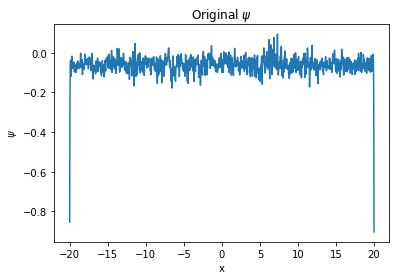

In [78]:
plt.plot(x, psi.real)
plt.title("Original $\psi$")
plt.xlabel("x")
plt.ylabel("$\psi$")
plt.show()

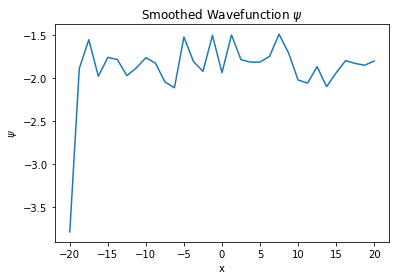

In [79]:
# Do the FT on the wavefunction
fft_psi = fftpack.fft(psi.real)
# Half the produced value as the FT is symmetric
fft_psi = fft_psi[:int(len(fft_psi) / 2)]
# plt.plot(x, fft_psi)

# Plot the FT to visualise the results.
# plt.plot(fft_psi)
# plt.show()

# Chop the FT to keep only the most important harmonics
fft_psi = fft_psi[:33]
# Plot the minimised FT
# plt.plot(fft_psi)
# plt.show()

# Perform an inverse FT to get the smoothed wavefunction back
psi = fftpack.ifft(fft_psi)

# Plot the final wavefunction to show the result.
x_range = numpy.linspace(a, b, len(psi.real))
plt.plot(x_range, psi.real)
plt.title("Smoothed Wavefunction $\psi$")
plt.xlabel("x")
plt.ylabel("$\psi$")
plt.show()